# Embedding Models:
**Purpose:** Try additional embedding approaches including document based embedding on the email bodies data

**Note**: To run this notebook, you must have already generated the embedding corpora by using the `build_w2vs` ipynb file, and must have at some point preprocessed the email data. To preprocess the email data and pickle it for later use, run up until the preprocessing steps in the `tfidf_model` ipynb file (located in `../tfidf_models`).

**Authors**: Jake Epstein & Matt Kenney

---

## Setup
#### Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Flatten, Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.0.1
Eager mode:  True
Hub version:  0.7.0
GPU is available


In [2]:
import sys
sys.path.insert(1, '../nlp_engine')
from MLFunctions import PrintDot, plot_history, clear_memory, predict_with_uncertainty, get_monte_carlo_accuracy
from Preprocessing import preprocess_training_text, preprocess_training_text_with_stops

Spacy model is using GPU


#### Step 2: Define Functions to Proccess the Embedding Matrix from W2V Models, Create Document Vectors, etc.

In [3]:
def process_embedding_matrix(embedding_matrix, word2id):
    
    """
    Prepare Embedding Matrix for use in a model by adding tokens for unknown
    words and for blank tokens (We will pad our sentences to all include a 
    set number of words. As such, we need to handle 'empty' or 'blank' words
    that trail sentences that are less than the set length.)
    """
    
    if 'UNK' not in word2id:
        unk_val = len(embedding_matrix)
        print('unk_val set to:', unk_val)
        word2id.update(UNK = unk_val)
        embedding_matrix = np.vstack([embedding_matrix,  np.mean(embedding_matrix, axis=0)])
        
    # add 'EMPTY_INDEX' token to embedding_matrix to classify padded words as meaningless (np.zeros)
    if 'EMPTY_INDEX' not in word2id:
        empty_val= 0
        print('empty_val set to:', empty_val)
        word2id.update(EMPTY_INDEX = empty_val)
        embedding_matrix = np.vstack([np.zeros((1, embedding_matrix.shape[1])), embedding_matrix])
        
    return embedding_matrix

In [4]:
def get_index(input_list, embedding_matrix, word2id, maskzero=False):
    
    max_length = 0
    index_list_list = []
    word_list = []
    
    # Loop through each sentence in the input:
    for sentence in input_list:
        word_list = sentence.split()
        index_list = []
        
        # Update max_length:
        if len(word_list) > max_length:
            max_length = len(word_list)
        
        # Return indicies corresponding to each word in the 
        for word in word_list:
            
            # Word is found in the vocabulary of the w2v model:
            if word in word2id:
                index_list.append(word2id[word])
            # Unknown word
            else:
                index_list.append(word2id.get('UNK'))
                
        index_list_list.append(index_list)
        
    # Pad the index list according to max_length of the input:
    index_list_list = pad_sequences(index_list_list, maxlen = max_length, padding='post', value=word2id.get('EMPTY_INDEX'))
    return index_list_list, max_length

In [5]:
# function to generate document embedding vectors
def generate_doc_embedding_data(data, embedding_matrix) -> pd.DataFrame:
    
    new_data = []
    embedding_vectors = tf.nn.embedding_lookup(
                        params=embedding_matrix,
                        ids=data,
                        max_norm=None,
                        name=None)
    
    embedding_sums = np.sum(embedding_vectors.numpy(), axis=1)
    normed_doc_embedding_vectors = normalize(embedding_sums, norm='l2', axis=1, copy=True, return_norm=False)
    return pd.DataFrame(normed_doc_embedding_vectors)

#### Step 3: Define Functions to Generate Standard Embedding Models and Doc Embedding Models

In [6]:
def build_embedding_model(embedding_matrix, word2id, max_length, labels, optimizer, lr, num_units):
    
    embedding_dim = embedding_matrix.shape[1]
    vocab_size = len(word2id)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, mask_zero=True))
    model.add(LSTM(units=num_units, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(labels.keys()), activation='softmax'))
    
    # Parameters
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(lr)
        
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(lr)
    
    elif optimizer == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(lr)
    else:
        print("ERROR: No optimizer passed")
        return None

    model.compile(loss='kullback_leibler_divergence',
                    optimizer=optimizer,
                    metrics=['accuracy'])
    
    return model

In [7]:
# Using Keras Sequential model for regression analyses
def build_doc_model(features, labels, optimizer, activations, lr, drop_rate, layer1_size, layer2_size=None, layer3_size=None, layer4_size=None):
    
    model = Sequential()
    model.add(Input(shape=[len(features.keys())], name="Doc-Embedding-Features"))
    model.add(Dense(layer1_size, activation=activations[0], input_shape=[len(features.keys())]))
    
    if layer2_size:
        model.add(Dropout(drop_rate, trainable=True))
        model.add(Dense(layer2_size, activation=activations[1]))
    
    if layer3_size:
        model.add(Dropout(drop_rate, trainable=True))
        model.add(Dense(layer3_size, activation=activations[2]))
    
    if layer4_size:
        model.add(Dropout(drop_rate, trainable=True))
        model.add(Dense(layer4_size, activation=activations[3]))
    
    model.add(Dropout(drop_rate, trainable=True))
    model.add(Dense(len(labels.keys()), activation='softmax', name="softmax_output"))
    
    # Parameters
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(lr)
    elif optimizer == 'adamax':
        optimizer = tf.keras.optimizers.Adamax()
    elif optimizer == 'nadam':
        optimizer = tf.keras.optimizers.Nadam()
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(lr)
    elif optimizer == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad()
    elif optimizer == 'adadelta':
        optimizer = tf.keras.optimizers.Adadelta()
    else:
        print("ERROR: No optimizer passed")
        return None
    
    
    model.compile(loss='kullback_leibler_divergence',
                optimizer=optimizer,
                metrics=['accuracy'])
    
    return model

## Testing the Performance of Different W2V Models
using both standard and document embedding techniques. Below, we test 
1. Document and standard embedding approach with the pega corpus only
2. Document and standard approach with the pega & brown corpus combined
3. A google hub model, which uses a pretrained embedding model under the hood, and employs a document embedding approach.

### 1. Embedding approaches with the Pega corpus (only) w2v model 

#### Load Model

In [8]:
# Load the Model
word_vectors = KeyedVectors.load("../saved_models/word_embeddings/pega_corpus.kv", mmap='r')

In [9]:
# create a dictionary to map words to index in embedding matrix, create embedding matrix
word2id = {k: v.index for k, v in word_vectors.vocab.items()}
embedding_matrix = word_vectors.vectors
embedding_matrix = embedding_matrix.astype('float32')

# See how word2id maps words to the index of their embedding vectors
list(word2id.items())[:5]

[('join', 605),
 ('boston', 2420),
 ('pegaworld', 314),
 ('inspire', 405),
 ('june', 1650)]

In [10]:
vocab_size, embedding_dim = embedding_matrix.shape
print('Vocab Size:', vocab_size, '\nEmbedding Vector Size:', embedding_dim)

Vocab Size: 8853 
Embedding Vector Size: 300


#### Load Data

In [11]:
# Load the Data (Assuming it has already been preprocessed)
assigned_bugs = pd.read_pickle("../data/pickles/preprocessed_bugs.pkl")
category='combined'

In [12]:
# Prepare Embedding Matrix for use with ML:
embedding_matrix = process_embedding_matrix(embedding_matrix, word2id)

unk_val set to: 8853
empty_val set to: 0


#### Generate Standard and Document Embedding Representations + Train-Test Split

In [13]:
# Index Examples can be passed directly into standard embedding models.
# They contain the indicies of word vectors representing each word
# in a given email, and are padded by 'empty_val' indicies
index_examples, max_length = get_index(assigned_bugs[category], embedding_matrix, word2id)

In [14]:
# Document Vectors Represent the entire document as a single embedding vector
# The doc vector is the result of combining and normalizing the vectors
# representing each word in the email
document_vectors = generate_doc_embedding_data(index_examples, embedding_matrix)

In [15]:
backlog_labels = pd.get_dummies(assigned_bugs['backlog_id']).astype('float32')
std_embedding_data = pd.DataFrame(index_examples.astype('float32'))
document_vectors = pd.DataFrame(document_vectors.astype('float32'))

In [16]:
seed = np.random.randint(1000)

std_train_features, std_test_features, train_labels, test_labels = train_test_split(std_embedding_data, backlog_labels, 
                                                                                    test_size=0.2, random_state=seed)
doc_train_features, doc_test_features, train_labels, test_labels = train_test_split(document_vectors, backlog_labels, 
                                                                                    test_size=0.2, random_state=seed)

#### Build and Train the Models

In [17]:
try:
    pega_std_emb_model
except NameError:
    pega_std_emb_model = None
    
clear_memory(pega_std_emb_model)
pega_std_emb_model = build_embedding_model(embedding_matrix=embedding_matrix, 
                                           word2id=word2id, 
                                           max_length=max_length, 
                                           labels=train_labels, 
                                           optimizer='adam', 
                                           lr=0.001, 
                                           num_units=100)

In [18]:
pega_std_emb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 295, 300)          2656500   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 47)                4747      
Total params: 2,821,647
Trainable params: 2,821,647
Non-trainable params: 0
_________________________________________________________________


In [19]:
## Define Params for this model:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=20)
pega_std_emb_history = pega_std_emb_model.fit(std_train_features, 
                                              train_labels,
                                              epochs=1000, 
                                              validation_split = 0.1, 
                                              callbacks=[early_stop, PrintDot()],
                                              verbose=1)

Train on 3912 samples, validate on 435 samples
Epoch 1/1000
3912/3912 [==============================] - 39s 10ms/sample - loss: 3.2506 - accuracy: 0.2030 - val_loss: 3.0143 - val_accuracy: 0.2322
Epoch 2/1000
3912/3912 [==============================] - 38s 10ms/sample - loss: 2.7233 - accuracy: 0.2983 - val_loss: 2.5935 - val_accuracy: 0.3218
Epoch 3/1000
3912/3912 [==============================] - 38s 10ms/sample - loss: 2.3060 - accuracy: 0.3768 - val_loss: 2.3107 - val_accuracy: 0.3655
Epoch 4/1000
3912/3912 [==============================] - 38s 10ms/sample - loss: 1.9638 - accuracy: 0.4716 - val_loss: 2.1121 - val_accuracy: 0.4230
Epoch 5/1000
3912/3912 [==============================] - 38s 10ms/sample - loss: 1.7102 - accuracy: 0.5422 - val_loss: 1.9365 - val_accuracy: 0.4644
Epoch 6/1000
3912/3912 [==============================] - 38s 10ms/sample - loss: 1.4915 - accuracy: 0.6076 - val_loss: 1.8600 - val_accuracy: 0.4920
Epoch 7/1000
3912/3912 [=============================

<Figure size 432x288 with 0 Axes>

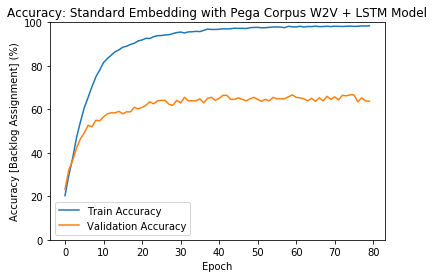

In [20]:
plot_history(pega_std_emb_history, "Accuracy: Standard Embedding with Pega Corpus W2V + LSTM Model")

In [21]:
clear_memory(pega_std_emb_model)

In [22]:
try:
    pega_doc_emb_model
except NameError:
    pega_doc_emb_model = None
    
clear_memory(pega_doc_emb_model)
pega_doc_emb_model = build_doc_model(features = doc_train_features, 
                                     labels = train_labels, 
                                     optimizer = 'adam',
                                     activations =['elu', 'tanh'],
                                     lr = 0.0001, 
                                     drop_rate=0.3,
                                     layer1_size = 200,
                                     layer2_size= 100, 
                                     layer3_size= None,
                                     layer4_size= None)

In [23]:
pega_doc_emb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               60200     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
softmax_output (Dense)       (None, 47)                4747      
Total params: 85,047
Trainable params: 85,047
Non-trainable params: 0
_________________________________________________________________


In [24]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=20)
pega_doc_emb_history = pega_doc_emb_model.fit(doc_train_features, 
                                 train_labels, 
                                 epochs=1000, 
                                 validation_split = 0.2, 
                                 callbacks=[early_stop, PrintDot()],
                                 verbose=0)


....................................................................................................
.............................................................

<Figure size 432x288 with 0 Axes>

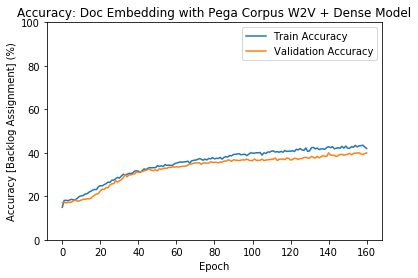

In [25]:
plot_history(pega_doc_emb_history, "Accuracy: Doc Embedding with Pega Corpus W2V + Dense Model")

In [26]:
clear_memory(pega_doc_emb_model)

### 1. Embedding approaches with the combined (Pega + Brown) corpus w2v model 

In [27]:
# Load the Model
word_vectors = KeyedVectors.load("../saved_models/word_embeddings/combined_corpus.kv", mmap='r')

In [28]:
# create a dictionary to map words to index in embedding matrix, create embedding matrix
word2id = {k: v.index for k, v in word_vectors.vocab.items()}
embedding_matrix = word_vectors.vectors
embedding_matrix = embedding_matrix.astype('float32')

# See how word2id maps words to the index of their embedding vectors
list(word2id.items())[:5]

[('make', 161), ('complex', 757), ('simple', 435), ('year', 174), ('.', 0)]

In [29]:
vocab_size, embedding_dim = embedding_matrix.shape
print('Vocab Size:', vocab_size, '\nEmbedding Vector Size:', embedding_dim)

Vocab Size: 17905 
Embedding Vector Size: 300


In [30]:
# Prepare Embedding Matrix for use with ML:
embedding_matrix = process_embedding_matrix(embedding_matrix, word2id)

unk_val set to: 17905
empty_val set to: 0


#### Generate Standard and Document Embedding Representations + Train-Test Split

In [31]:
# Index Examples can be passed directly into standard embedding models.
# They contain the indicies of word vectors representing each word
# in a given email, and are padded by 'empty_val' indicies
index_examples, max_length = get_index(assigned_bugs[category], embedding_matrix, word2id)

In [32]:
# Document Vectors Represent the entire document as a single embedding vector
# The doc vector is the result of combining and normalizing the vectors
# representing each word in the email
document_vectors = generate_doc_embedding_data(index_examples, embedding_matrix)

In [33]:
backlog_labels = pd.get_dummies(assigned_bugs['backlog_id']).astype('float32')
std_embedding_data = pd.DataFrame(index_examples.astype('float32'))
document_vectors = pd.DataFrame(document_vectors.astype('float32'))

In [34]:
seed = np.random.randint(1000)

std_train_features, std_test_features, train_labels, test_labels = train_test_split(std_embedding_data, backlog_labels, 
                                                                                    test_size=0.2, random_state=seed)
doc_train_features, doc_test_features, train_labels, test_labels = train_test_split(document_vectors, backlog_labels, 
                                                                                    test_size=0.2, random_state=seed)

#### Build and Train the Models

In [35]:
try:
    combined_std_emb_model
except NameError:
    combined_std_emb_model = None
    
clear_memory(combined_std_emb_model)
combined_std_emb_model = build_embedding_model(embedding_matrix=embedding_matrix, 
                                           word2id=word2id, 
                                           max_length=max_length, 
                                           labels=train_labels, 
                                           optimizer='adam', 
                                           lr=0.001, 
                                           num_units=100)

In [36]:
combined_std_emb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 295, 300)          5372100   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 47)                4747      
Total params: 5,537,247
Trainable params: 5,537,247
Non-trainable params: 0
_________________________________________________________________


In [37]:
## Define Params for this model:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=20)
combined_std_emb_history = combined_std_emb_model.fit(std_train_features, 
                                              train_labels,
                                              epochs=1000, 
                                              validation_split = 0.1, 
                                              callbacks=[early_stop, PrintDot()],
                                              verbose=1)

Train on 3912 samples, validate on 435 samples
Epoch 1/1000
3912/3912 [==============================] - 39s 10ms/sample - loss: 3.2550 - accuracy: 0.1996 - val_loss: 3.1014 - val_accuracy: 0.2161
Epoch 2/1000
3912/3912 [==============================] - 39s 10ms/sample - loss: 2.7404 - accuracy: 0.2935 - val_loss: 2.7564 - val_accuracy: 0.2828
Epoch 3/1000
3912/3912 [==============================] - 38s 10ms/sample - loss: 2.3314 - accuracy: 0.3816 - val_loss: 2.4869 - val_accuracy: 0.3402
Epoch 4/1000
3912/3912 [==============================] - 38s 10ms/sample - loss: 2.0250 - accuracy: 0.4632 - val_loss: 2.3005 - val_accuracy: 0.3954
Epoch 5/1000
3912/3912 [==============================] - 38s 10ms/sample - loss: 1.7399 - accuracy: 0.5386 - val_loss: 2.1521 - val_accuracy: 0.4322
Epoch 6/1000
3912/3912 [==============================] - 38s 10ms/sample - loss: 1.5099 - accuracy: 0.5979 - val_loss: 2.0524 - val_accuracy: 0.4621
Epoch 7/1000
3912/3912 [=============================

<Figure size 432x288 with 0 Axes>

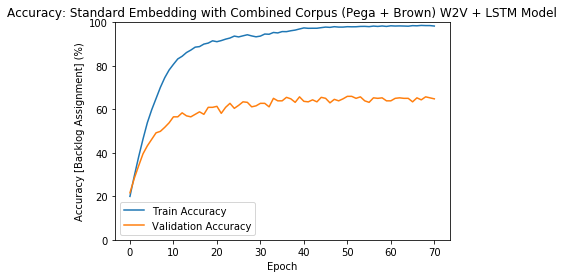

In [38]:
plot_history(combined_std_emb_history, "Accuracy: Standard Embedding with Combined Corpus (Pega + Brown) W2V + LSTM Model")

In [39]:
clear_memory(combined_std_emb_model)

In [40]:
try:
    combined_doc_emb_model
except NameError:
    combined_doc_emb_model = None
    
clear_memory(combined_doc_emb_model)
combined_doc_emb_model = build_doc_model(features = doc_train_features, 
                                     labels = train_labels, 
                                     optimizer = 'adam',
                                     activations =['tanh', 'tanh'],
                                     lr = 0.0001, 
                                     drop_rate=0.3,
                                     layer1_size = 200,
                                     layer2_size= 100, 
                                     layer3_size= None,
                                     layer4_size= None)

In [41]:
combined_doc_emb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               60200     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
softmax_output (Dense)       (None, 47)                4747      
Total params: 85,047
Trainable params: 85,047
Non-trainable params: 0
_________________________________________________________________


In [42]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=15)
combined_doc_emb_history = combined_doc_emb_model.fit(doc_train_features, 
                                 train_labels, 
                                 epochs=1000, 
                                 validation_split = 0.2, 
                                 callbacks=[early_stop, PrintDot()],
                                 verbose=0)


....................................................................................................
....................................................................................................
.................................................................

<Figure size 432x288 with 0 Axes>

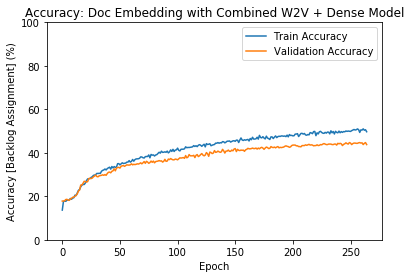

In [43]:
plot_history(combined_doc_emb_history, "Accuracy: Doc Embedding with Combined W2V + Dense Model")

In [44]:
clear_memory(pega_doc_emb_history)

### 3. Google Hub Model
Note that the google hub model takes plain text as input and handles the tokenization steps itself.

In [45]:
# Using Keras Sequential model for regression analyses
def build_hub_model(embedding_model_url, labels, optimizer, lr, drop_rate, num_units):
    
    hub_layer = hub.KerasLayer(embedding_model_url, input_shape=[], 
                           dtype=tf.string)
    
    model = Sequential()
    
    model.add(hub_layer)
    model.add(Dropout(drop_rate))
    model.add(Dense(num_units, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(len(labels.keys()), activation='softmax'))

    # Parameters
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(lr)
        
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(lr)
        
    else:
        print("ERROR: No optimizer passed")
        return None

    model.compile(loss='kullback_leibler_divergence',
                    optimizer=optimizer,
                    metrics=['accuracy'])
    
    return model

In [46]:
bytes_literal_text = assigned_bugs[category].astype('|S')

In [47]:
train_features, test_features, train_labels, test_labels = train_test_split(bytes_literal_text, backlog_labels, test_size=0.2)

In [48]:
try:
    hub_model
except NameError:
    hub_model = None
    
clear_memory(hub_model)

hub_model = build_hub_model(embedding_model_url="https://tfhub.dev/google/universal-sentence-encoder/4",
                            labels=train_labels,
                            optimizer='adam',
                            lr=0.0001,
                            drop_rate=0.3,
                            num_units=256)

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [49]:
hub_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 47)                12079     
Total params: 256,941,231
Trainable params: 143,407
Non-trainable params: 256,797,824
_________________________________________________________________


In [50]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
hub_history = hub_model.fit(train_features.to_numpy(), 
                            train_labels.to_numpy(), 
                            epochs=1000,
                            validation_split = 0.2, 
                            callbacks = [early_stop, PrintDot()],
                            verbose=0)


....................................................................................................
.................

<Figure size 432x288 with 0 Axes>

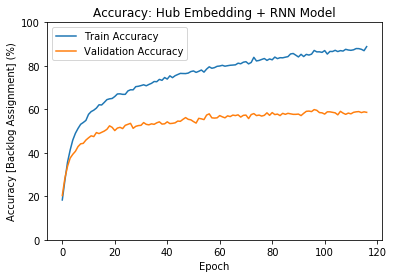

In [51]:
plot_history(hub_history, "Accuracy: Hub Doc Embedding + Dense Model")